In [222]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from torch.utils.data import Dataset, DataLoader

# Modelos Neuronales III

Autor: Jorge García González (Universidad de Málaga)

Última Actualización: 1/10/2025

Asignatura: Programación para la Inteligencia Artificial

Bien, en los cuadernos anteriores ya hemos empezado a entrenar modelos neuronales usando PyTorch y algunas herramientas de PyTorch para gestionar los datos durante el entrenamiento. Antes de seguir, vamos a ver cómo encaja tener un *DataLoader* en nuestro bucle de entrenamiento. Vamos a necesitar crear un *Dataset*. vamos a hacer uno genérico aunque no sea muy eficiente.

Pero antes, toca rescatar algunas funciones. get_data_from_a_polynomial y get_data_from_a_line han sido modificadas para que den resultados también menores en el dominio menor que 0.

In [223]:
def generate_polynomial(c_list):
  """
  Función para generar una función que aplique un polinomio.
  Args:
    c_list: Lista de coeficientes del polinomio. ej: [2,1,0] representa el polinomio y = 2x**2 + x + 0
  """
  def apply_polynomial(x):
    """
    Función para aplicar un polinomio.
    Args:
      x: las entradas a las que aplicarle el polinomio.
    """
    y = torch.cat([c*x[None,:]**index for index, c in enumerate(reversed(c_list))]).sum(dim=0)  # Para cada coeficiente (desde el final) operamos todas
                                                                                                # las x elevándolo a su índice (0,1,2,etc) y obtenemos
                                                                                                # una fila.
                                                                                                # El cat concatena las filas, así cada columna tiene,
                                                                                                # para un solo x, las operaciones de cada término del
                                                                                                # polinomio.
                                                                                                # Finalmente sumamos a lo largo de las columnas.
    return y

  return apply_polynomial

def get_data_from_a_polynomial(poly, n, sigma=2, range=50):
  """
  Función que devuelve datos a partir de una recta. Recordemos que la ecuación de la recta está definida por y=mx+b.
  Args:
    poly: Función que aplica un polinomio.
    n: número de datos que queremos obtener.
    sigma: desviación típica para el ruido que añadiremos a los datos (2 por defecto).
    range: extremos del rango [-range,range] en el eje x en el que queremos situar los datos (50 por defecto).
  """
  x = 2*range*torch.rand(n)-range                                                     # Generamos los datos en el eje x.
  y = poly(x)                                                                         # Obtenemos los valores del polinomio para cada x.
  noise_x = torch.normal(torch.zeros_like(y), sigma*torch.ones_like(y))               # Generamos un vector de ruido gaussiano para el eje x.
  noise_y = torch.normal(torch.zeros_like(y), sigma*torch.ones_like(y))               # Generamos un vector de ruido gaussiano para el eje y.
  x_with_noise = x + noise_x
  y_with_noise = y + noise_y

  data = torch.cat((x_with_noise[:,None], y_with_noise[:,None]), dim=1)
  return data

def get_data_from_a_line(m, b, n, sigma=2, range=50):
  """
  Función que devuelve datos a partir de una recta. Recordemos que la ecuación de la recta está definida por y=mx+b.
  Args:
    m: inclinación de la recta.
    b: ordenada en el origen de la recta.
    n: número de datos que queremos obtener.
    sigma: desviación típica para el ruido que añadiremos a los datos (2 por defecto).
    range: extremo del rango [0,rango] en el eje x en el que queremos situar los datos (50 por defecto).
  """
  x = 2*range*torch.rand(n)-range                                       # Generamos los datos en el eje x.
  y = m*x+b                                                             # Obtemeos la posición correspondiente en el eje y.
  noise_x = torch.normal(torch.zeros_like(y), sigma*torch.ones_like(y)) # Generamos un vector de ruido gaussiano para el eje x.
  noise_y = torch.normal(torch.zeros_like(y), sigma*torch.ones_like(y)) # Generamos un vector de ruido gaussiano para el eje y.
  x_with_noise = x + noise_x
  y_with_noise = y + noise_y

  data = torch.cat((x_with_noise[:,None], y_with_noise[:,None]), dim=1)
  return data

Vamos a hacer un *Dataset* que simplemente guarde llos valores de x e y. Por simplicidad vamos a aceptar que siempre estén en memoria. Esta vez vamos a omitir los transform.

In [224]:
class XYDataset(Dataset):
  def __init__(self, x, y):
    self.x = x
    self.y = y

  def __len__(self):
    # La longitud del Dataset coincide con el número de elementos del vector x.
    return self.x.numel()

  def __getitem__(self, idx):
    x = self.x[idx]
    y = self.y[idx]
    return torch.tensor([x]), torch.tensor([y])

Nótese que como elementos de la tupla devuelvo un vector de tamaño uno en vez de simplemente un número. Esto es para que luego los lotes tengan tamaño Bx1.

Ahora puedo generar un *Dataset* fácilmente.

In [225]:
line_data = get_data_from_a_line(1, 0, 5, sigma=0.2, range=1)
x = line_data[:,0]
y = line_data[:,1]
line_xydataset = XYDataset(x, y)
print(len(line_xydataset))

5


Ahora tenemos que adaptar nuestro bucle de entrenamiento para funcionar en base a los lotes que genera un *DataLoader*

In [226]:
def learning_loop(dataloader, model, epochs, loss_fn, learning_rate, optimizer):
  epoch_loss_list = []

  opt = optimizer(
    model.parameters(),
    lr=learning_rate
  )

  for epoch in tqdm(range(epochs), desc="epoch:"):
    step_loss_list = []
    for x_true, y_true in dataloader:
      y_pred = model(x_true)                              # Forward
      opt.zero_grad()
      loss = loss_fn(y_pred, y_true)
      loss.backward()                                     # Backward
      step_loss_list.append(loss.clone().detach())
      opt.step()
    epoch_loss_list.append(torch.tensor(step_loss_list).mean())

  return model, epoch_loss_list

Este bucle representa la lógica general que *habitualmente* sigue un proceso de ajuste de parámetros respecto a las épocas. Entendemos por un paso de entrenamiento (un *step*), el paso que se da tras cada secuencia de *forward* y *backward* (el bucle interno). Ese bucle debería recorrer todos los datos del conjunto y a eso llamamos una época (*epoch*). Aunque según el problema puede ocurrir, la regla general es medir la longitud de los entrenamientos en épocas (el bucle exterior).

¿La dimensión ficticia que añadíamos a los datos de entrada en cuadernos anteriores antes de hacer el *forward*? La necesitabamos porque PyTorch asume que lo que se proporciona es un *batch* de datos. Por tanto, espera que la primera dimensión del tensor se corresponda con el tamaño del *batch*. Si tenemos N ejemplos en un vector de tamaño N y se le proporciona tal cuál, no sabe desambiguar si se trata de un único ejemplo compuesto por N valores o N ejemplos de 1 valor. Por eso le creabamos una dimensión ficticia al final y que PyTorch encontrara un tensor de tamaño Nx1 (N ejemplos de tamaño 1).

Como regla general, la primera dimensión es el *batch* y, por ejemplo, si trabajaramos con imágenes, cada batch tendría tamaño BxCxHxW (*batch*, canal, alto y ancho).

El tamaño del *batch* es uno de los hiperparámetros que deben definirse a la hora del entrenamiento, pero antes de hablar de eso vamos  ahacer una prueba de nuestro nuevo bucle de entrenamiento para aprender una recta.

Número de parámetros 405


epoch:: 100%|██████████| 20000/20000 [00:25<00:00, 770.70it/s]


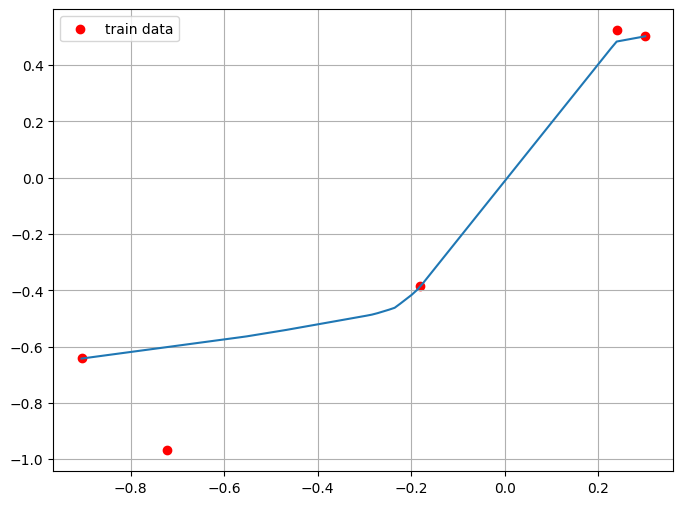

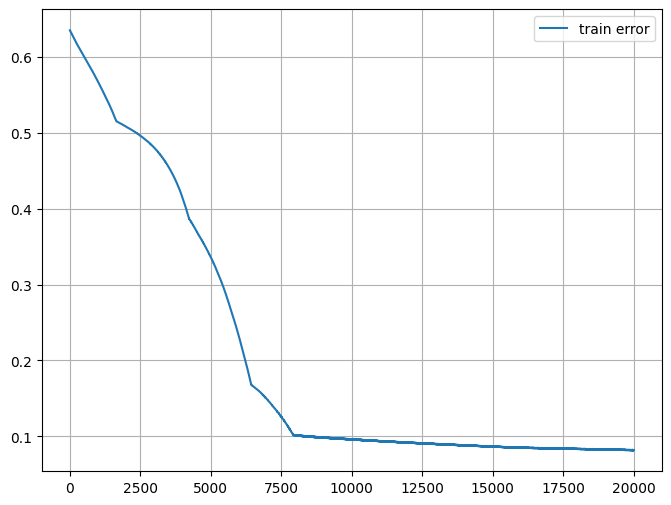

In [227]:
batch_size = 5
learning_rate = 1e-3
epochs = 20000
loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.SGD

line_dataloader = DataLoader(line_xydataset, batch_size = batch_size, shuffle=True)

model = torch.nn.Sequential(
    torch.nn.Linear(1,12),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(12,12),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(12,16),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(16,1),
)

print(f"Número de parámetros {torch.tensor([p.numel() for p in model.parameters()]).sum()}")

model, loss_list = learning_loop(line_dataloader, model, epochs, loss_fn, learning_rate, optimizer)

# Para mostrarlos sí que voy a obtener todos los elementos del Dataset.

data = torch.tensor([example for example in line_xydataset])
x_data = data[:,0]
y_data = data[:,1]
plt.figure(figsize=(8,6))
x = torch.linspace(x_data.min(), x_data.max(), 100)[:,None]
y = model(x).detach()
plt.plot(x, y)
plt.scatter(x_data, y_data, marker='o', c='r', label="train data")
#plt.scatter(val_line_data[:,0], val_line_data[:,1], marker='o', c='g', label="val data")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(range(epochs), loss_list, label="train error")
#plt.plot(range(0,steps, 10), loss_val_list, label="val error")
plt.legend()
plt.grid(True)
plt.show()

¡UPS! No ha salido muy recta que digamos...

Vale, sí, esta vez hemos hecho trampas. Le hemos dado muy pocos datos que sumado al ruido de los mismos han hecho que no converga a la recta que debería. Hemos provocado el problema pudiendo evitarlo fácilmente, pero ha sido por una cuestión didáctica. Estamos ante un caso de sobreajuste (*overfitting*). Cuando el modelo se ajusta más a los datos de lo que es deseable y pierde en cierta medida la capacidad de *generalizar*.

Se entiende que en asignaturas anteriores se ha estudiado el fenómeno del sobreajuste, así que no vamos a extendernos sobre él. La pregunta es: ¿Cómo analizamos el sobreajuste en Aprendizaje Profundo? Pues con la estrategia que se usa en general para el Aprendizaje Computacional: necesitamos evaluar el modelo en datos que no se usan para entrenar. ¡Solo que en Aprendizaje profundo acostumbramos a hacerlo mientras entrenamos! A esos datos los solemos llamar conjunto de validación (en contraposición al conjunto de entrenamiento).

¡Vamos a contemplarlo en nuestro bucle de entrenamiento!

In [241]:
def learning_loop_with_val(train_dataloader, val_dataloader, model, epochs, loss_fn, learning_rate, optimizer):
  train_loss_list = []
  val_loss_list = []
  opt = optimizer(
    model.parameters(),
    lr=learning_rate
  )

  for epoch in tqdm(range(epochs), desc="epoch:"):
    train_step_loss_list = []
    for x_train_true, y_train_true in train_dataloader:
      y_pred = model(x_train_true)                              # Forward
      opt.zero_grad()
      loss = loss_fn(y_pred, y_train_true)
      loss.backward()                                     # Backward
      train_step_loss_list.append(loss.clone().detach())
      opt.step()
    train_loss_list.append(torch.tensor(train_step_loss_list).mean())

    # Realizaremos una época de validación cada 10 pasos de entrenamiento para
    # minimizar los cálculos que no son estrictamente necesarios.
    if epoch % 10 == 0:
      val_step_loss_list = []
      with torch.no_grad():
        for x_val_true, y_val_true in val_dataloader:
          y_val_pred = model(x_val_true)
          loss_val = loss_fn(y_val_pred, y_val_true)
          val_step_loss_list.append(loss_val)
        val_loss_list.append(torch.tensor(val_step_loss_list).mean())

  return model, train_loss_list, val_loss_list

Generamos un *Dataset* de validación...

In [229]:
line_val_data = get_data_from_a_line(1, 0, 5, sigma=0.2, range=1)
x_val = line_val_data[:,0]
y_val = line_val_data[:,1]
val_line_xydataset = XYDataset(x_val, y_val)

Número de parámetros 405


epoch:: 100%|██████████| 20000/20000 [00:27<00:00, 733.52it/s]


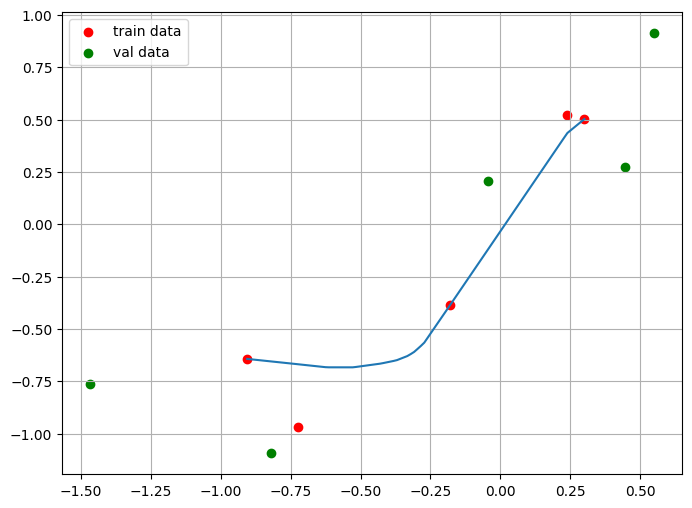

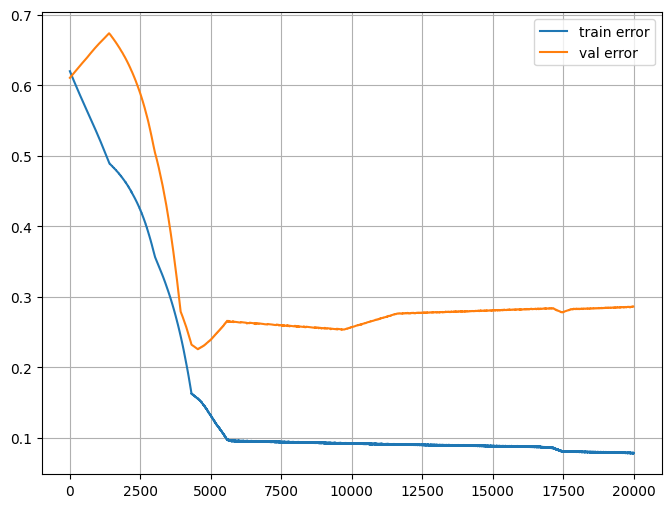

In [245]:
batch_size = 5
learning_rate = 1e-3
epochs = 20000
loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.SGD

val_line_dataloader = DataLoader(val_line_xydataset, batch_size=batch_size, shuffle=True)
train_line_dataloader = DataLoader(line_xydataset, batch_size = batch_size, shuffle=True)

model = torch.nn.Sequential(
    torch.nn.Linear(1,12),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(12,12),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(12,16),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(16,1),
)

print(f"Número de parámetros {torch.tensor([p.numel() for p in model.parameters()]).sum()}")

model, train_loss_list, val_loss_list = learning_loop_with_val(train_line_dataloader, val_line_dataloader, model, epochs, loss_fn, learning_rate, optimizer)

# Para mostrarlos sí que voy a obtener todos los elementos del Dataset.

train_data = torch.tensor([example for example in line_xydataset])
train_x_data = train_data[:,0]
train_y_data = train_data[:,1]
val_data = torch.tensor([example for example in val_line_xydataset])
val_x_data = val_data[:,0]
val_y_data = val_data[:,1]
plt.figure(figsize=(8,6))
x = torch.linspace(train_x_data.min(), train_x_data.max(), 100)[:,None]
y = model(x).detach()
plt.plot(x, y)
plt.scatter(train_x_data, train_y_data, marker='o', c='r', label="train data")
plt.scatter(val_x_data, val_y_data, marker='o', c='g', label="val data")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(range(epochs), train_loss_list, label="train error")
plt.plot(range(0,epochs, 10), val_loss_list, label="val error")
plt.legend()
plt.grid(True)
plt.show()

Ahora tenemos dos evoluciones del error para evaluar qué tal está aprendiendo nuestro modelo. El error sobre los datos entrenados nos da una impresión de si el modelo está aprendiendo o hay algún problema, mientras que el error sobre los datos de validación nos da una impresión de la capacidad de generalizar del modelo. Nos dice cómoe voluciona el error esperable con datos con los que no se ha entrenado.

Típicamente nos interesa seguir entrenando el modelo mientras ambos errores vayan descendiendo. Si el error sobre los datos de entrenamiento desciende, pero el error sobre los datos de validación aumenta (como está ocurriendo en nuestro ejemplo), sabemos que nuestro modelo está sobreentrenando (pierde capacidad de generalización).

¿Cuál es el punto interesante? Típicamente, antes de que empiece el sobreentrenamiento. En el ejemplo de arriba podemos ver que nuestro modelo generalizaba mejor antes de la época 5000.

Antes de términar debemos volver al asunto de los lotes. Uno podría pensar que la útilidad de los lotes es meramente técnica. Típicamente trabajamos con una cantidad de datos superior a la que podemos procesar o mantener en memoria a la vez, así que los dividimos. Es una razón, sí, pero hay alguna ventaja más.

Para entrenar estamos usando el Stochastic Gradient Descent... Si solo se basara en el descenso del gradiente se llamaría Gradient Descent a secas, ¿no? ¿Cuál es la parte estocástica? Justamente la elección de los datos. En nuestras primeras versiones del entrenamiento vimos cómo usar solo un dato era contraproducente para la convergencia. Sin embargo, también tiene una ventaja: ¡Ayuda a "evitar" mínimos locales! Si simplemente obtuvieramos el gradiente de todos nuestros datos, el camino que ese gradiente marca desde un punto de partida en la función que queremos minimizar sería determinista (para un proceso de aprendizaje concreto, un ratio de aprendizaje concreto, etc). Si por el camino encuentra un mínimo local, la "dirección" de salida siempre va a ser la misma. Si esa "dirección" no ayuda a "escapar" del mínimo local... No va a cambiar.

Por otro lado, coger distintos subconjuntos de datos hacen que el gradiente sea inestable. No tan "aproximado" al ideal como podría ser. En cada iteración sería distinto. Si entramos en un mínimo local, de manera natural en cada iteración se probarían distintas "direcciones" de salida. Esa es la razón por la que es recomendable indicarle al *DataLoader* que reordene los datos tras cada época. ¡Así las distintas combinaciones de datos producen gradientes distintos en cada época! Es meter ruido en el "camino" del entrenamiento, pero ese ruido nos ayuda a salir de mínimos del que un camino ideal y único no podría.

La siguiente imagen tomado prestada (;P) del libro Deep Learnign with PyTorch lo ilustra:

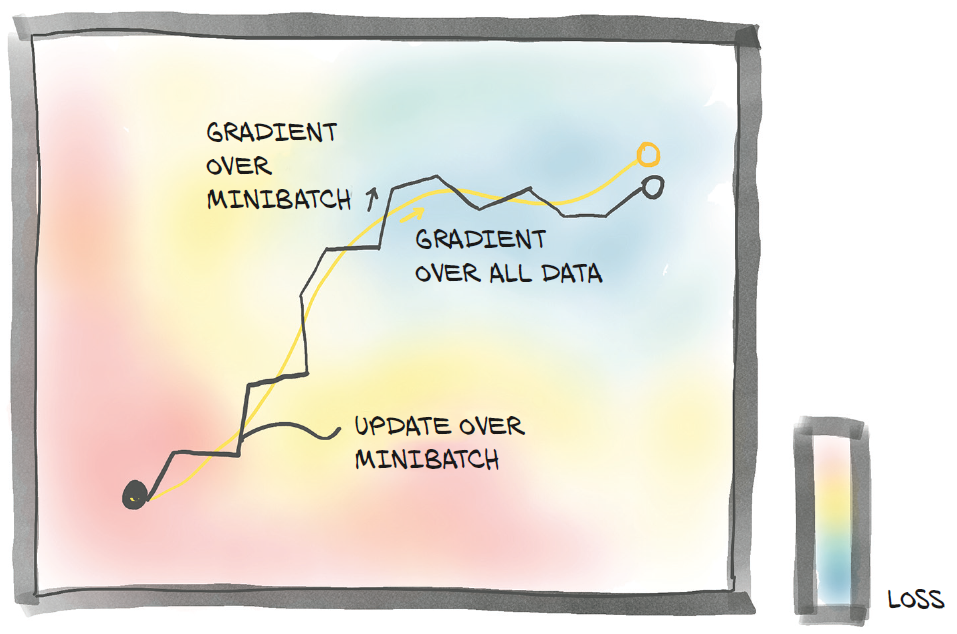

Ahora puede haber varias preguntas. Una es si esto es contraproducente porque nos saque del mínimo absoluto. La respuesta es que podría ocurrir, si es el mínimo absoluto, se espera que el proceso estocástico volviera a "lanzarnos dentro" de ese mínimo. Otra pregunta puede ser si el error que introducimos puede evitar la convergencia y... sí. Por eso es importante que hagamos ajustes pequeños (controlado con el ratio de aprendizaje). Para que si un conjunto de datos introduce tanto ruido que el gradiente se aleja mucho del ideal, solo hayamos dado un pequeño paso en una dirección "demasiado" equivocada.

¿Entonces de qué tamaño es ideal poner los lotes? Como muchas otras cosas... depende del problema y del hardwre. Lo ideal es aprovechar la capacidad de cómputo de la GPU, así que habría que usar lotes lo suficientemente grandes. Lotes demasiado pequeños (como un único ejemplo) tendrían demasiado ruido... Pero usar todos los datos nos hace perder el componente estocástico. Hay que buscar un punto de equilibrio.